<table style="font-size: 1em; padding: 0; margin: 0;">

<tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #182AEB; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #ffffff;">Deep Learning </span> for Satellite Image Classification</span> (Manning Publications)<br/>by <em>Daniel Buscombe</em></strong><br/><br/>
        <strong>> Chapter 1: Deliverable Solution </strong><br/>
    </p>  

! pip install rasterio

In [3]:
!pip install rasterio
!pip install imagecodecs

%matplotlib inline
import tensorflow as tf
import requests
import rasterio
import matplotlib.pyplot as plt
from skimage import io


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 32.3 MB/s eta 0:00:00


Then, we will download an image from the Sentinel2 dataset, similar to what we did in the Notebook that introduced this liveProject. As the image is quite big, this step can take a while to complete.

In [4]:
URL = "https://lp-prod-resources.s3.us-west-2.amazonaws.com/106/example_TCI_10m.jp2"
response = requests.get(URL)
open("test_img.jp2", "wb").write(response.content)

135223654

And from it we will create three ```TIFF``` images, using the same function ```write_image``` as in the previous notebook:

In [17]:
def write_image(input, output, band):
    with rasterio.open(input, driver='JP2OpenJPEG') as src_dataset:

        array = src_dataset.read(band)
        # Get a copy of the source dataset's profile. Thus our
        # destination dataset will have the same dimensions,
        # number of bands, data type, and georeferencing as the
        # source dataset.
        kwds = src_dataset.profile

        # Change the format driver for the destination dataset to
        # 'GTiff', short for GeoTIFF.
        kwds['driver'] = 'GTiff'

        # Add GeoTIFF-specific keyword arguments.
        kwds['tiled'] = True
        kwds['blockxsize'] = 256
        kwds['blockysize'] = 256
        kwds['photometric'] = 'YCbCr'
        kwds['compress'] = 'JPEG'

        with rasterio.open(output, 'w', **kwds) as dst_dataset:
            # Write data to the destination dataset.
            dst_dataset.write(array.astype(rasterio.uint8), 1)

input_file = 'test_img.jp2'
file_list = ['r1.tif', 'r2.tif', 'r3.tif']
[write_image(input_file, f, band) for f,band in zip(file_list, [1,2,3])]

[None, None, None]

We will now use only the first image we created. We read it using ```imread``` from ```scikit-image``` and display its dimensions

In [49]:
# !pip install tifffile

# img = io.imread('r1.tif')
# print(img.shape)

# !pip install gdal

from osgeo import gdal


# import matplotlib.pyplot as plt
# from skimage.io import imread
# # import gdal as gd
img = gdal.Open('r1.tif').ReadAsArray()

# # Read the image using imread from skimage
# img = imread('r1.tif')
print(img.shape)

# # Display the image using matplotlib



(3, 10980, 10980)


The image is indeed huge! It has 3 color channels and is 10980 pixels in both veritcal and horizontal dimenstion. We will use ```tf.image``` to rescale it to a smaller image

In [50]:
# Set the target size
target_size = (640, 640)

# Transpose the image tensor to match TensorFlow's channel-last format
image_tensor = tf.transpose(img, perm=[1, 2, 0])

# Resize the image while maintaining aspect ratio
resized_img = tf.image.resize(image_tensor, target_size, preserve_aspect_ratio=True)

# Transpose the resized image tensor back to the original format
img_array = tf.transpose(resized_img, perm=[2, 0, 1])

# Print the shape of the resized image
print(img_array.shape)






(3, 640, 640)


... then we will also rotate the image 90 degrees and store the rotated version in a new variable

In [51]:
img_r = tf.image.rot90(img_array)

print(img_r.shape)

(640, 3, 640)


We are finally ready to display the result

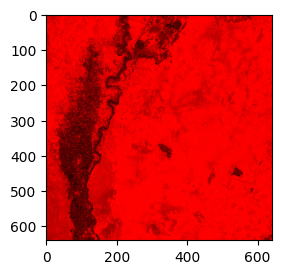

In [60]:


import matplotlib.pyplot as plt
from skimage.io import imshow
import numpy as np


img_array_reshaped = np.transpose(img_array.numpy(), (1, 2, 0))
img_r_reshaped = np.transpose(img_r.numpy(), (1, 2, 0))

# Display the images using matplotlib
plt.subplot(121)
plt.imshow(img_array_reshaped.astype('uint8'), cmap='gray')
plt.show()

